In [146]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import save_model, load_model
import random

num_samples = 400
hidden_size = 30
output_size = 1
epochs = 10000
learning_rate = 0.01
batch_size = 20

def max_absolute_error(y_true, y_pred):
    return tf.reduce_max(tf.abs(y_true - y_pred))

def std_error(y_true, y_pred):
    return tf.math.reduce_std(y_true - y_pred)

def target_function(x):
    return np.sin(20 * np.log(x))

np.random.seed(42)
x = np.random.uniform(1, 20, 400)
y = target_function(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.25, random_state=42)

# Normalize the inputs
x_train = x_train.reshape(-1, 1)
x_val = x_val.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)

# Create the neural network model
model = Sequential([
    Dense(hidden_size, activation='tanh', input_shape=(1,)),
    Dense(output_size, activation='linear')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=[max_absolute_error, std_error])

# Custom callback to store weights and biases during training
class WeightsBiasesLossHistory(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Store weights and biases
        weights_hidden, biases_hidden = self.model.layers[0].get_weights()
        weights_output, biases_output = self.model.layers[1].get_weights()

        weights_hidden_history.append(weights_hidden)
        biases_hidden_history.append(biases_hidden)
        weights_output_history.append(weights_output)
        biases_output_history.append(biases_output)

        # Store training and validation loss
        train_loss_history.append(logs['loss'])
        val_loss_history.append(logs['val_loss'])

    def on_test_end(self, logs=None):
        # Store test loss
        test_loss_history.append(logs['loss'])

weights_hidden_history = []
biases_hidden_history = []
weights_output_history = []
biases_output_history = []

train_loss_history = []
val_loss_history = []
test_loss_history = []

history = WeightsBiasesLossHistory()

2/2 [==============================] - 0s 5ms/step


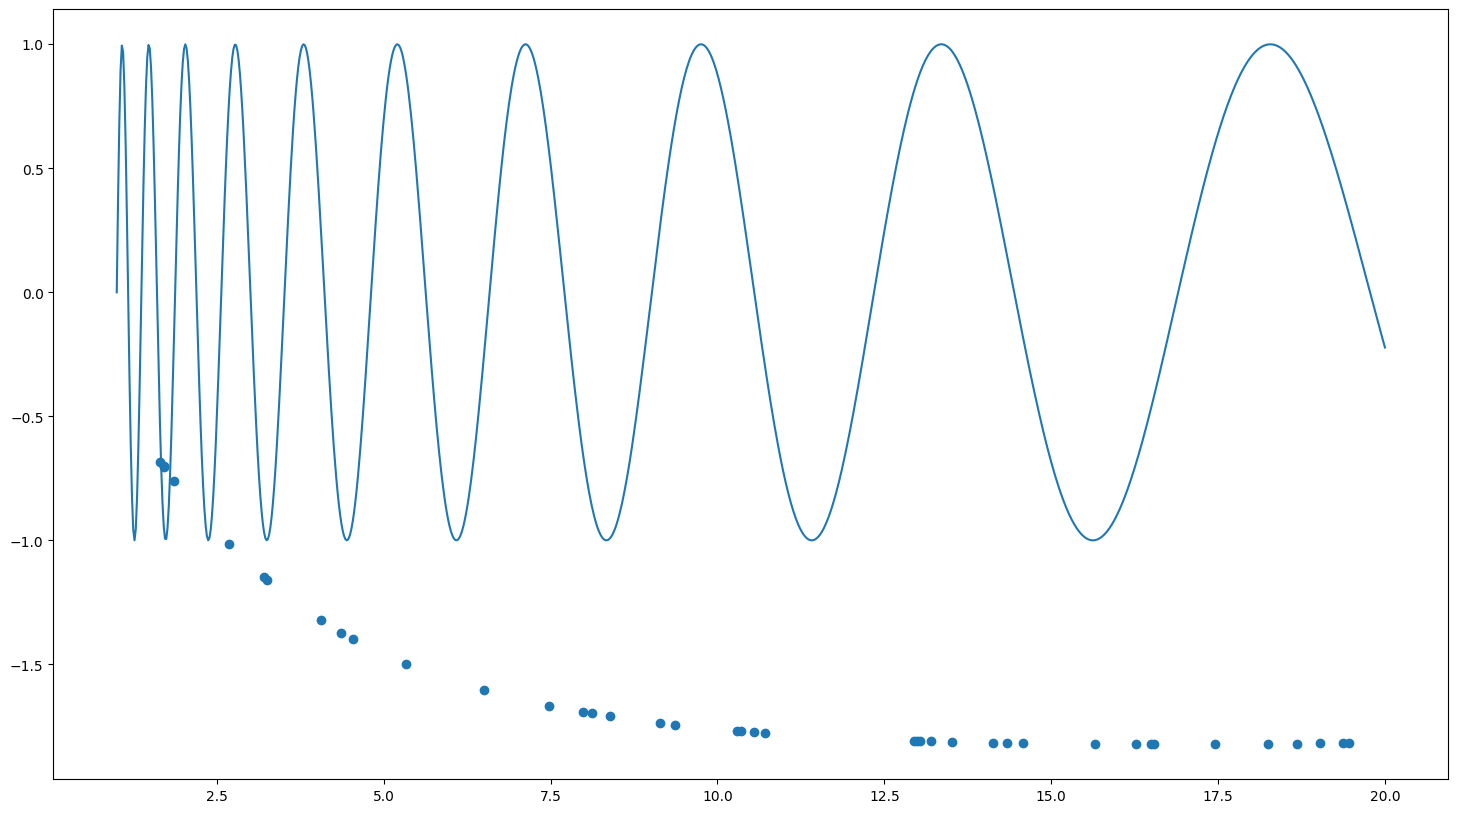

In [147]:
#evaluate model before training
y_predict_before = model.predict(x_test)
x_plot = np.linspace(1,20,1000)
plt.figure(figsize=(18, 10))
plt.plot(x_plot, target_function(x_plot))
plt.scatter(x_test, y_predict_before)

In [148]:
path_to_model = "./model_before_training.h5"
save_model(model, path_to_model)

In [149]:
# Train the model
history_callback = tf.keras.callbacks.History()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model.fit(np.array([x for x in x_train]), np.array([y for y in y_train]),
        epochs=epochs, batch_size=batch_size,
        validation_data=(np.array([x for x in x_val]), np.array([y for y in y_val])),
        callbacks=[history_callback, history, early_stopping], verbose=1)

Epoch 1/10000
12/12 [==============================] - 1s 15ms/step - loss: 1.1466 - max_absolute_error: 1.7351 - std_error: 0.6815 - val_loss: 0.7931 - val_max_absolute_error: 1.4834 - val_std_error: 0.7003
Epoch 2/10000
12/12 [==============================] - 0s 4ms/step - loss: 0.5696 - max_absolute_error: 1.2371 - std_error: 0.6796 - val_loss: 0.5513 - val_max_absolute_error: 1.1296 - val_std_error: 0.7067
Epoch 3/10000
12/12 [==============================] - 0s 5ms/step - loss: 0.4838 - max_absolute_error: 1.1342 - std_error: 0.6733 - val_loss: 0.5847 - val_max_absolute_error: 1.2218 - val_std_error: 0.6998
Epoch 4/10000
12/12 [==============================] - 0s 5ms/step - loss: 0.4777 - max_absolute_error: 1.1044 - std_error: 0.6594 - val_loss: 0.5385 - val_max_absolute_error: 1.0911 - val_std_error: 0.7044
Epoch 5/10000
12/12 [==============================] - 0s 4ms/step - loss: 0.4808 - max_absolute_error: 1.1219 - std_error: 0.6639 - val_loss: 0.5664 - val_max_absolute_er

In [150]:
# Evaluate the model on the test set
test_loss = model.evaluate(np.array([x for x in x_test]), np.array([y for y in y_test]), callbacks=[history])
type(test_loss)

2/2 [==============================] - 0s 7ms/step - loss: 0.1339 - max_absolute_error: 1.0207 - std_error: 0.3261


list

In [151]:
test_metrics = model.evaluate(x_test, y_test)
test_mse = test_metrics[model.metrics_names.index('loss')]
test_max_absolute_error = test_metrics[model.metrics_names.index('max_absolute_error')]
test_std_error = test_metrics[model.metrics_names.index('std_error')]

print(f"Test MSE: {test_mse:.4f}")
print(f"Test Max Absolute Error: {test_max_absolute_error:.4f}")
print(f"Test Standard Deviation of Error: {test_std_error:.4f}")

train_mse = history_callback.history['loss']
val_mse = history_callback.history['val_loss']
train_max_absolute_error = history_callback.history['max_absolute_error']
val_max_absolute_error = history_callback.history['val_max_absolute_error']
train_std_error = history_callback.history['std_error']
val_std_error = history_callback.history['val_std_error']

print(f"Train MSE: {train_mse[-1]:.4f}")
print(f"Train Max Absolute Error: {train_max_absolute_error[-1]:.4f}")
print(f"Train Standard Deviation of Error: {train_std_error[-1]:.4f}")

print(f"Validation MSE: {val_mse[-1]:.4f}")
print(f"Validation Max Absolute Error: {val_max_absolute_error[-1]:.4f}")
print(f"Validation Standard Deviation of Error: {val_std_error[-1]:.4f}")

2/2 [==============================] - 0s 4ms/step - loss: 0.1339 - max_absolute_error: 1.0207 - std_error: 0.3261
Test MSE: 0.1339
Test Max Absolute Error: 1.0207
Test Standard Deviation of Error: 0.3261
Train MSE: 0.0381
Train Max Absolute Error: 0.5713
Train Standard Deviation of Error: 0.1790
Validation MSE: 0.0809
Validation Max Absolute Error: 0.8720
Validation Standard Deviation of Error: 0.2648


In [152]:
path_to_model = "./model_after_training.h5"
save_model(model, path_to_model)

2/2 [==============================] - 0s 5ms/step


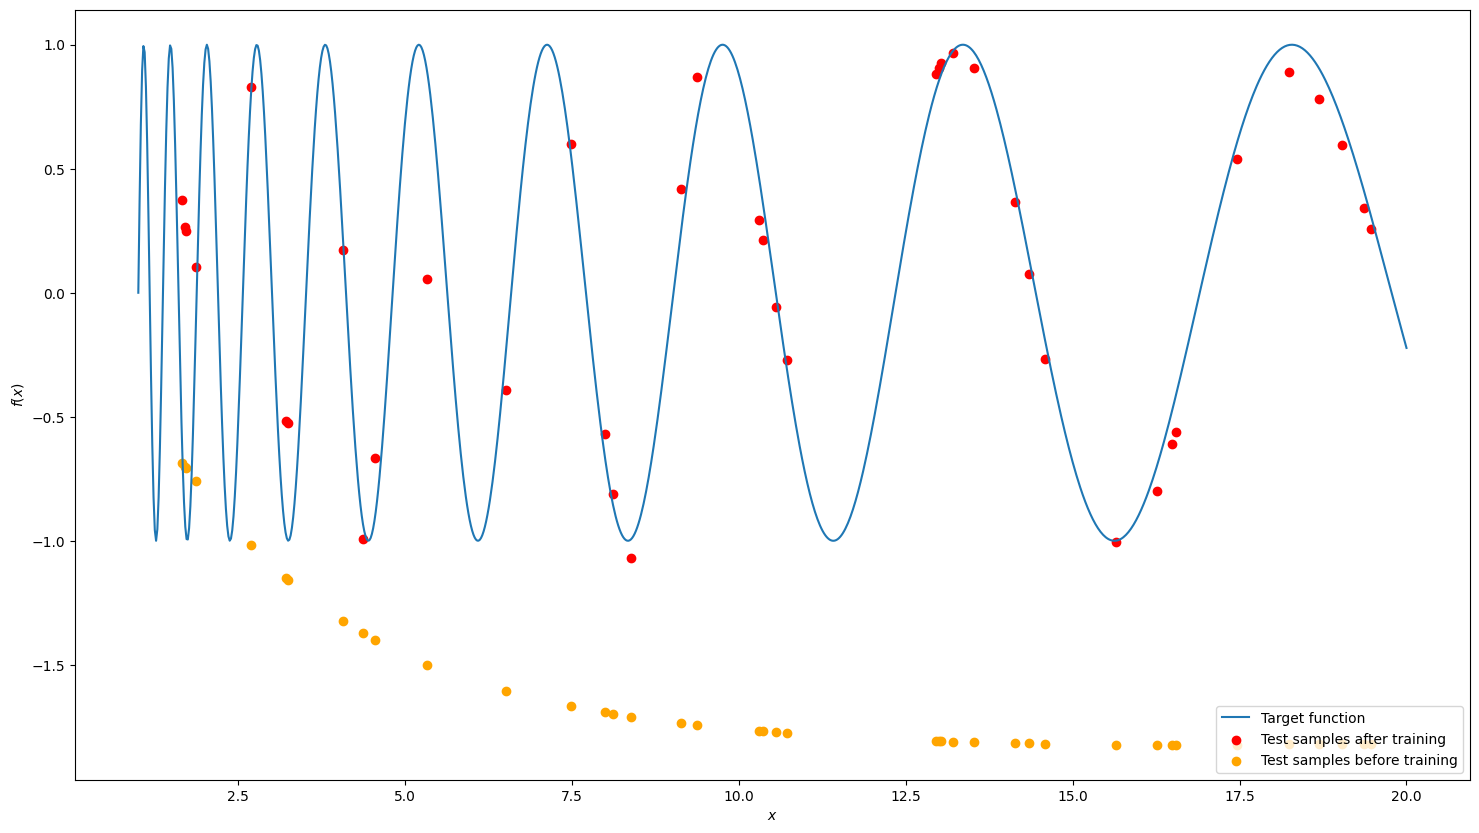

In [153]:
y_predict_after = model.predict(x_test)
x_plot = np.linspace(1, 20, 1000)

plt.figure(figsize=(18, 10))
plt.plot(x_plot, target_function(x_plot), label='Target function')
plt.scatter(x_test, y_predict_after, color='red', label='Test samples after training')
plt.scatter(x_test, y_predict_before, color='orange', label='Test samples before training')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='lower right')

In [154]:
def copy_list(list):
    import copy
    copy_of_list = np.array(list)
    copy_of_list = copy.deepcopy(copy_of_list)
    return copy_of_list

weight_hidden = copy_list(weights_hidden_history)
weight_hidden = weight_hidden.reshape(epochs, hidden_size)

biases_hidden = copy_list(biases_hidden_history)

weights_output = copy_list(weights_output_history)
weights_output = weights_output.reshape(epochs, hidden_size)

biases_output = copy_list(biases_output_history)

print(weight_hidden.shape)
print(biases_hidden.shape)
print(weights_output.shape)
print(biases_output.shape)

(10000, 30)
(10000, 30)
(10000, 30)
(10000, 1)


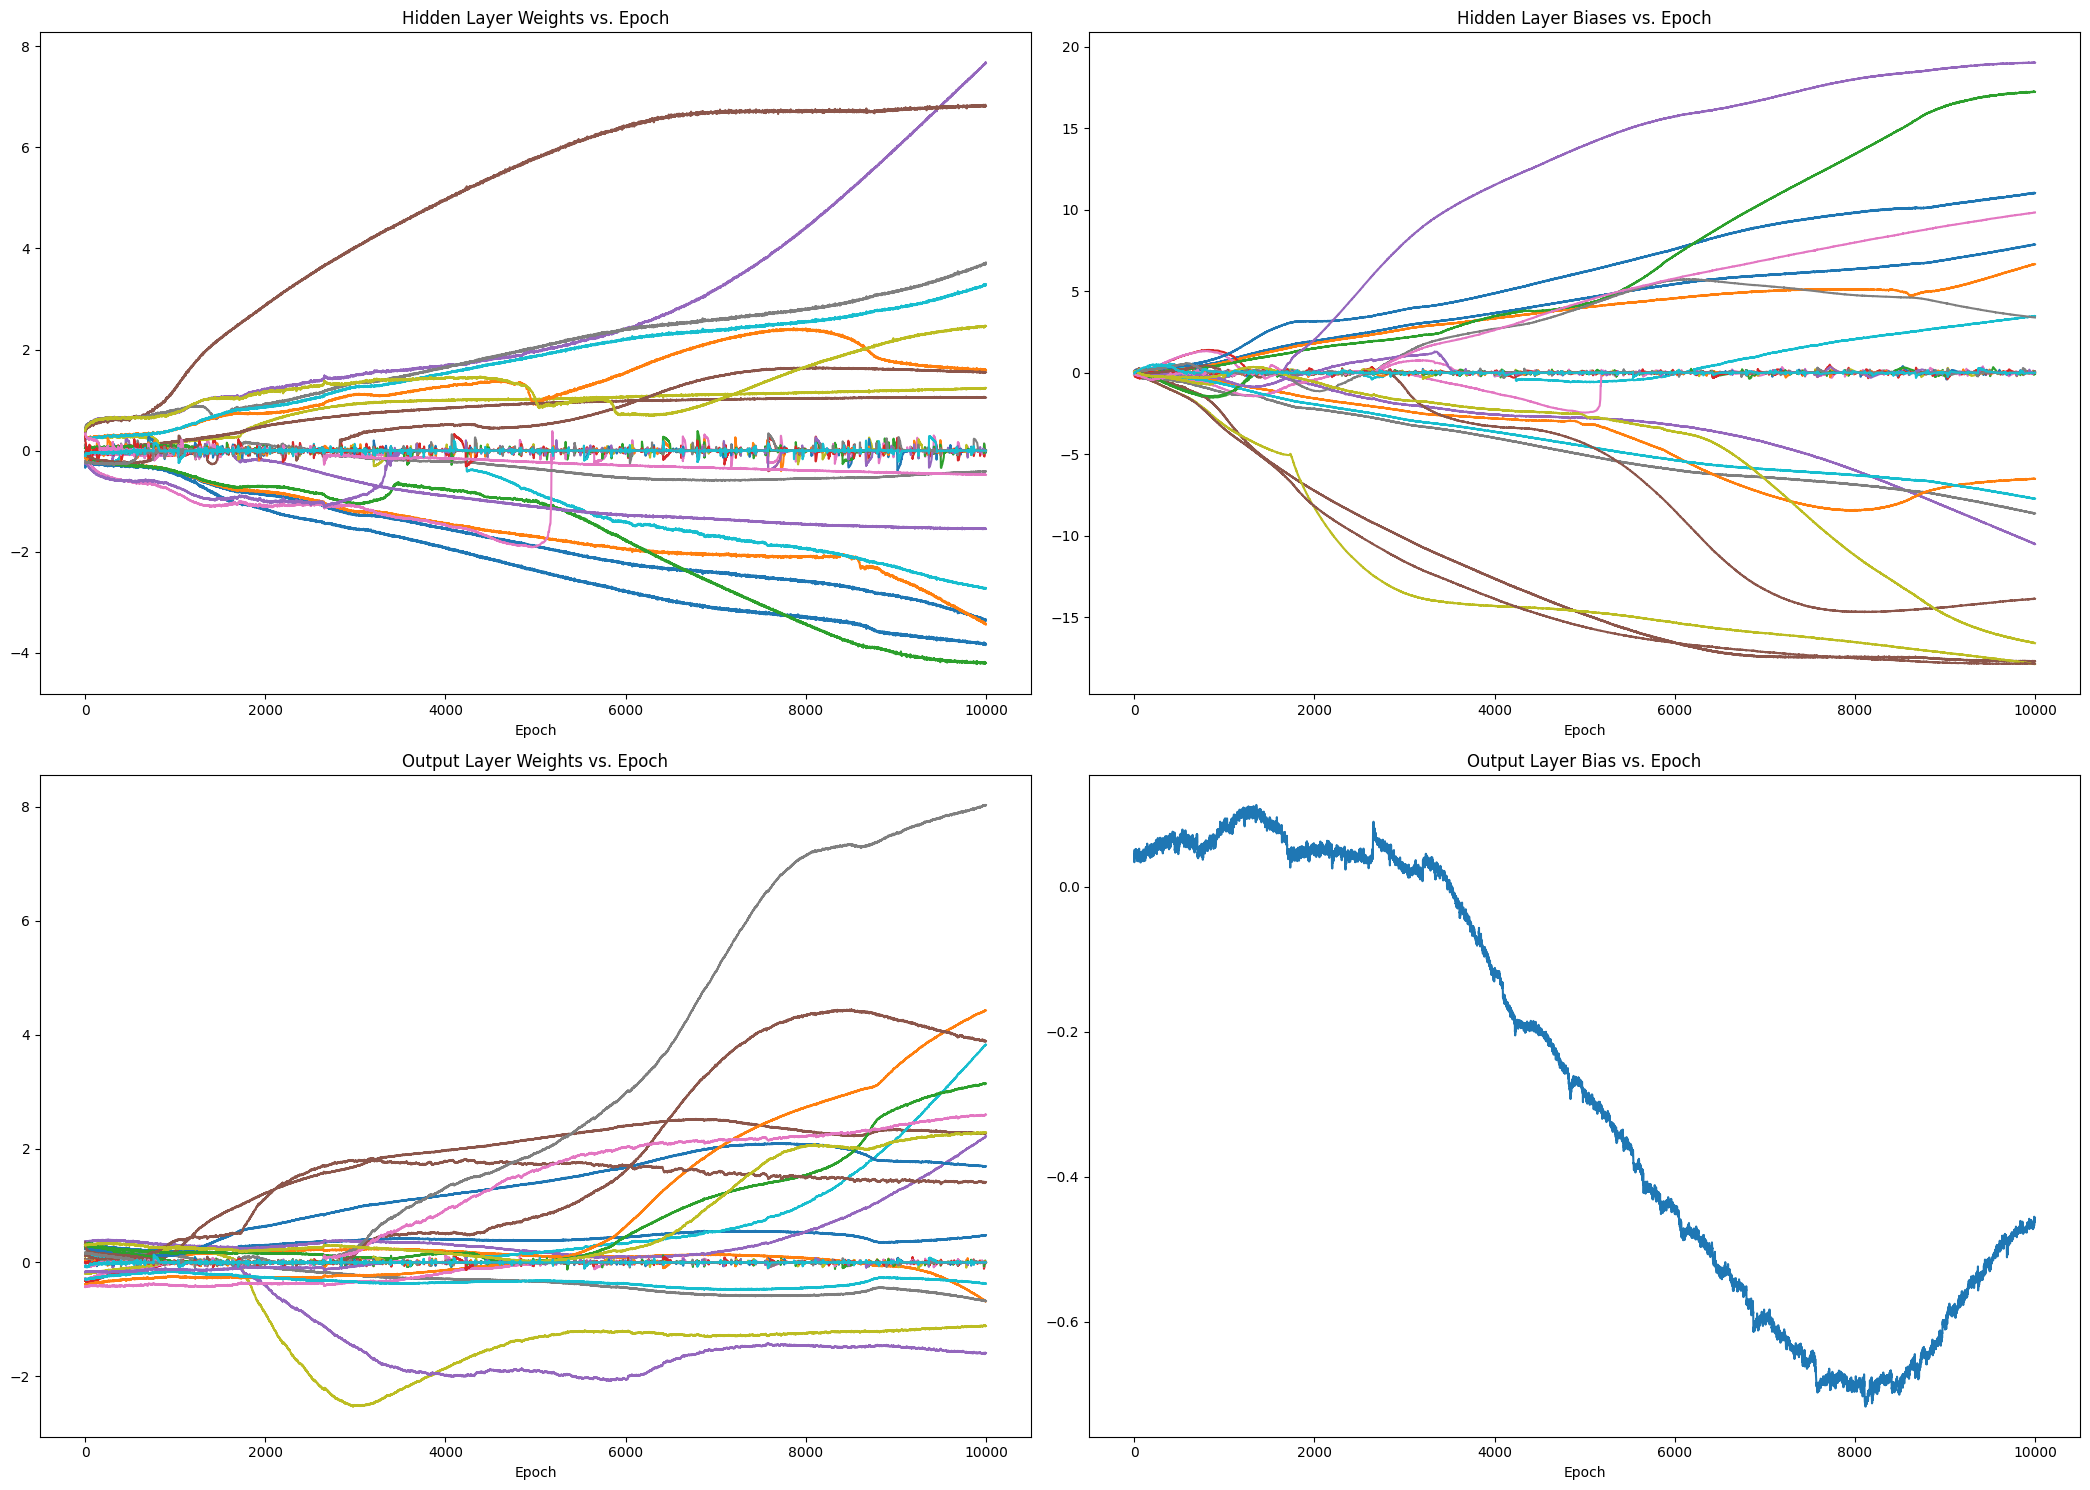

In [155]:
# Plot the graphics showing the dependencies of weights and biases on the epoch
fig, axes = plt.subplots(2, 2, figsize=(21, 15))

for i in range(hidden_size):
    weights_hidden_i = [epoch_weights[i] for epoch_weights in weight_hidden]
    biases_hidden_i = [epoch_biases[i] for epoch_biases in biases_hidden]
    weights_output_i = [epoch_weights[i] for epoch_weights in weights_output]

    axes[0, 0].plot(weights_hidden_i, label=f"Hidden Neuron {i + 1}")
    axes[0, 1].plot(biases_hidden_i, label=f"Hidden Neuron {i + 1}")
    axes[1, 0].plot(weights_output_i, label=f"Output Neuron {i + 1}")

axes[1, 1].plot([epoch_biases[0] for epoch_biases in biases_output_history], label="Output Neuron")

axes[0, 0].set_title("Hidden Layer Weights vs. Epoch")
axes[0, 1].set_title("Hidden Layer Biases vs. Epoch")
axes[1, 0].set_title("Output Layer Weights vs. Epoch")
axes[1, 1].set_title("Output Layer Bias vs. Epoch")

for ax in axes.flatten():
    ax.set_xlabel("Epoch")

plt.tight_layout()
plt.show()

In [156]:
path_to_model = "./model_after_training.h5"
save_model(model, path_to_model)

(10000,)
(10000,)
(10001,)
[0.79309171 0.55128986 0.58472735 ... 0.08349273 0.07553879 0.0808747 ]


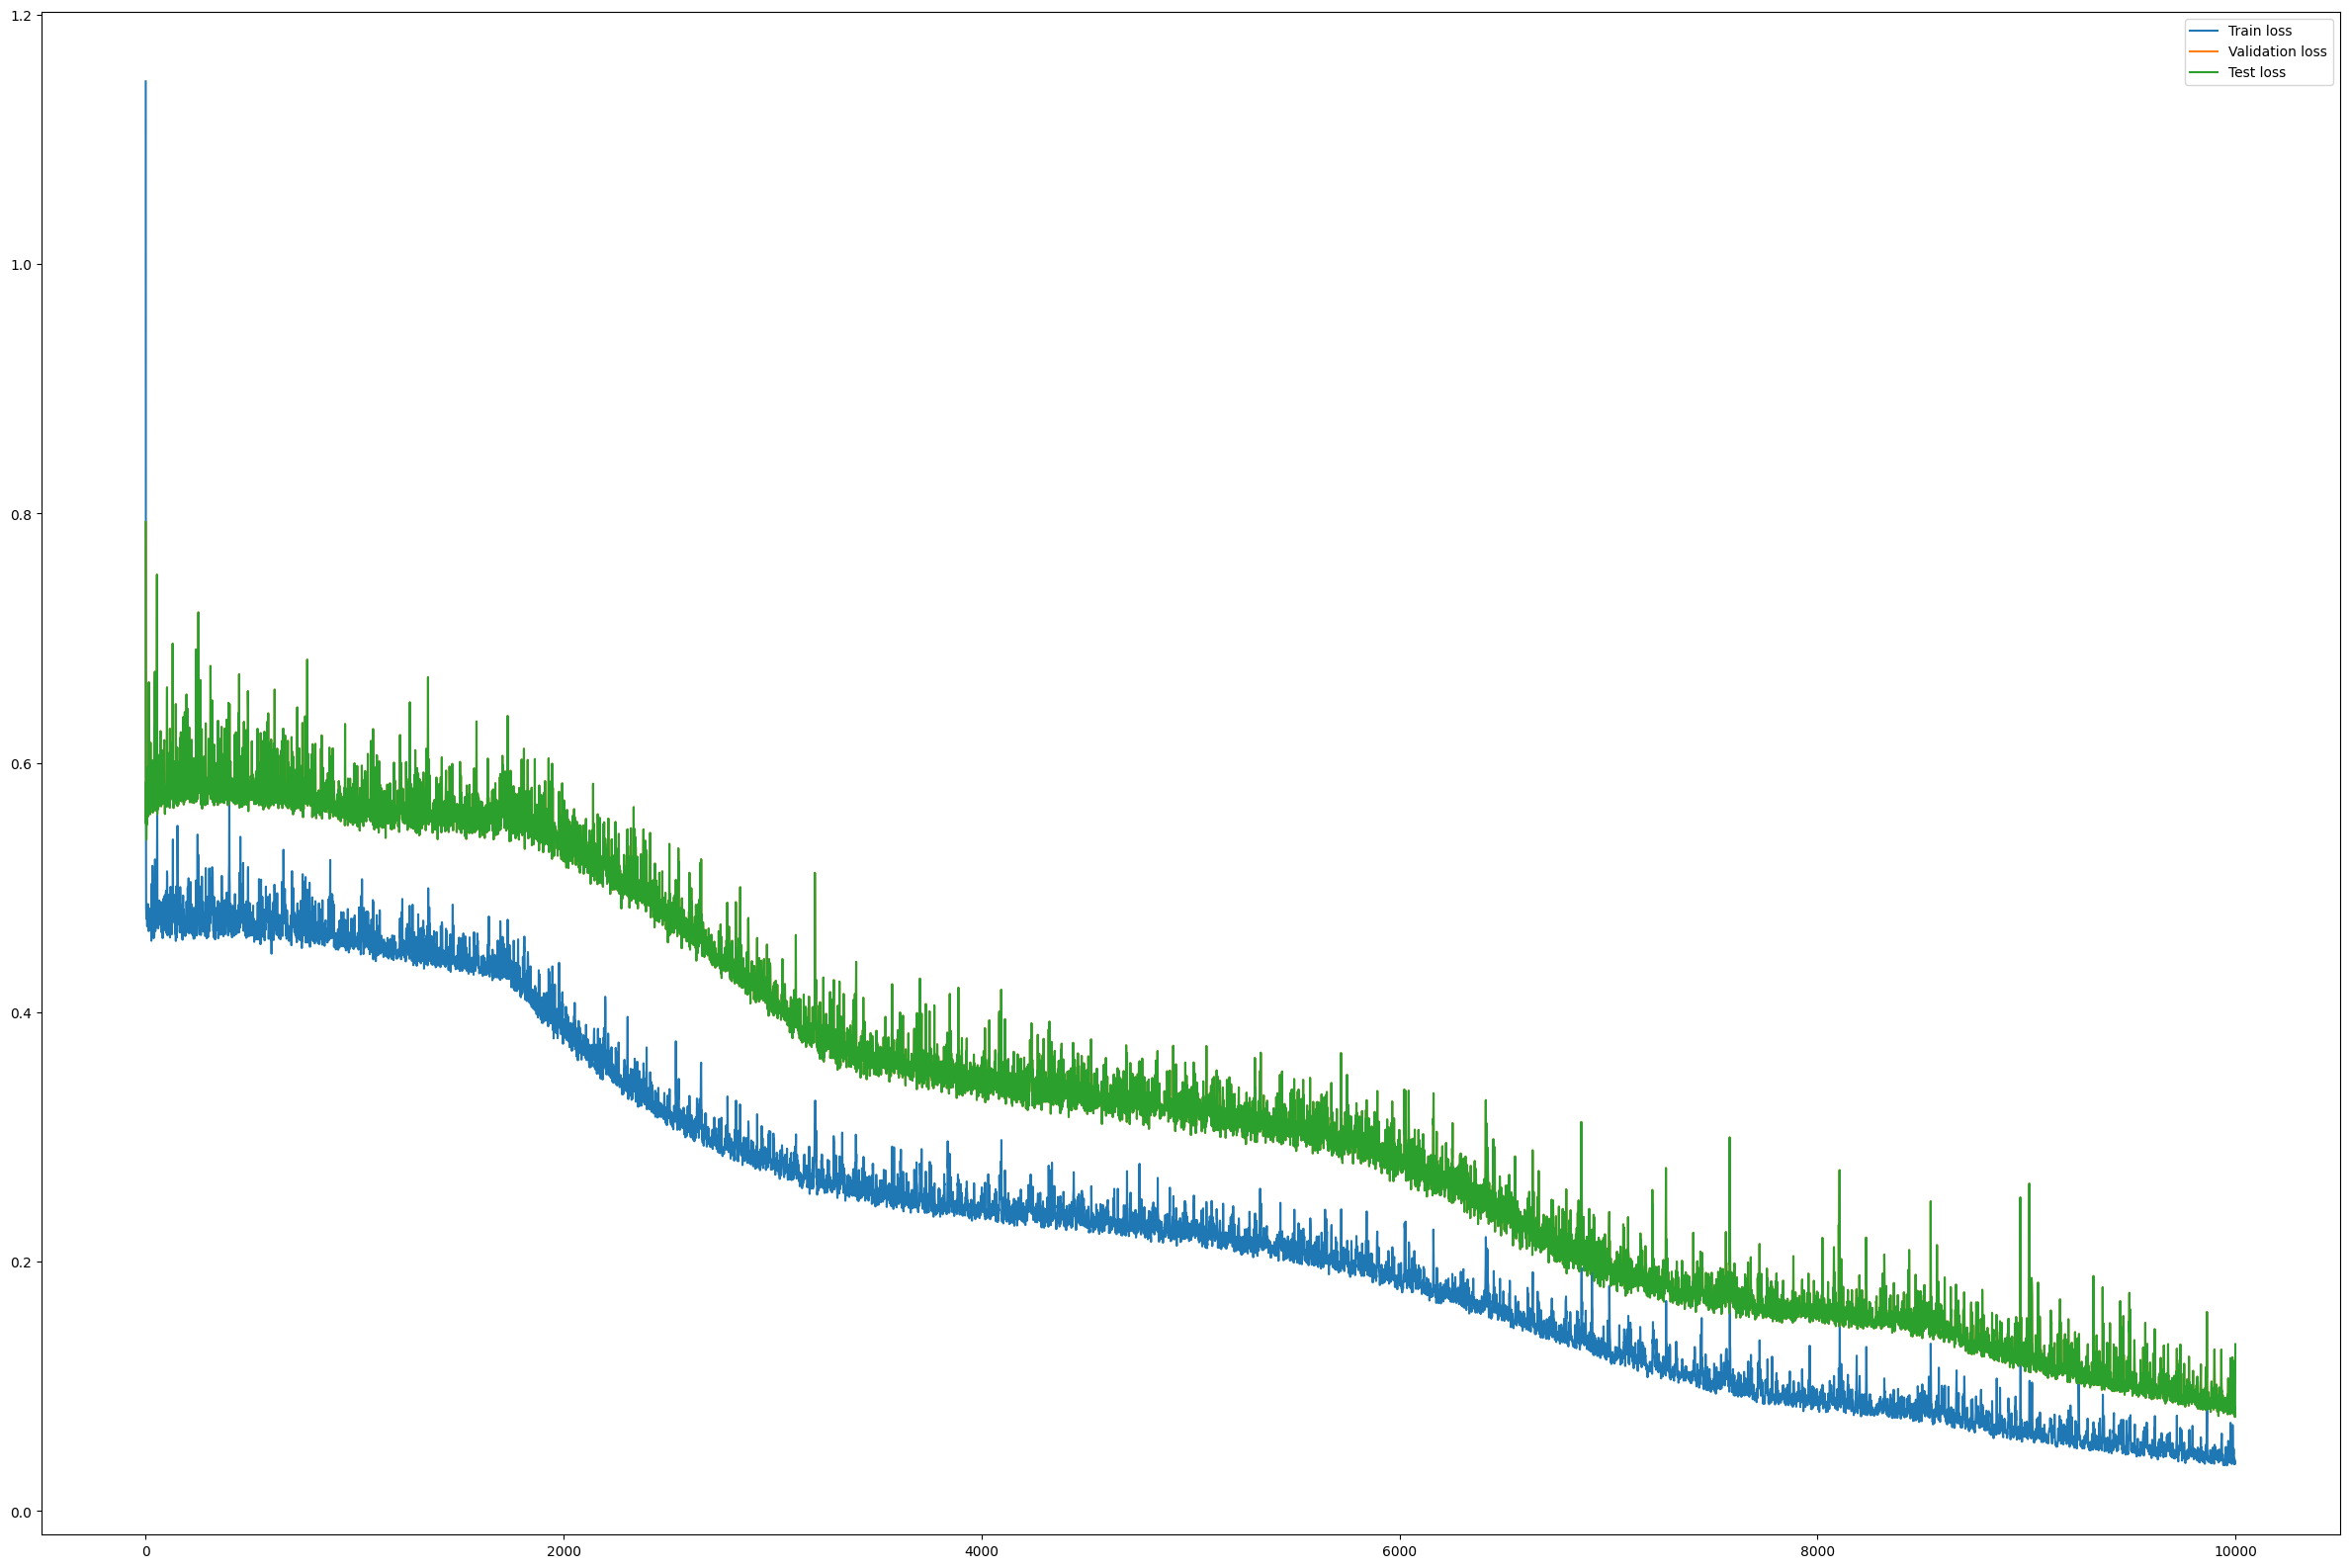

In [176]:
train_loss = copy_list(train_loss_history)
val_loss = copy_list(val_loss_history)
test_loss = copy_list(test_loss_history)

print(train_loss.shape)
print(val_loss.shape)
print(test_loss.shape)
print(val_loss)

plt.figure(figsize=(30, 20))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Validation loss')
plt.plot(test_loss, label='Test loss')
plt.legend()

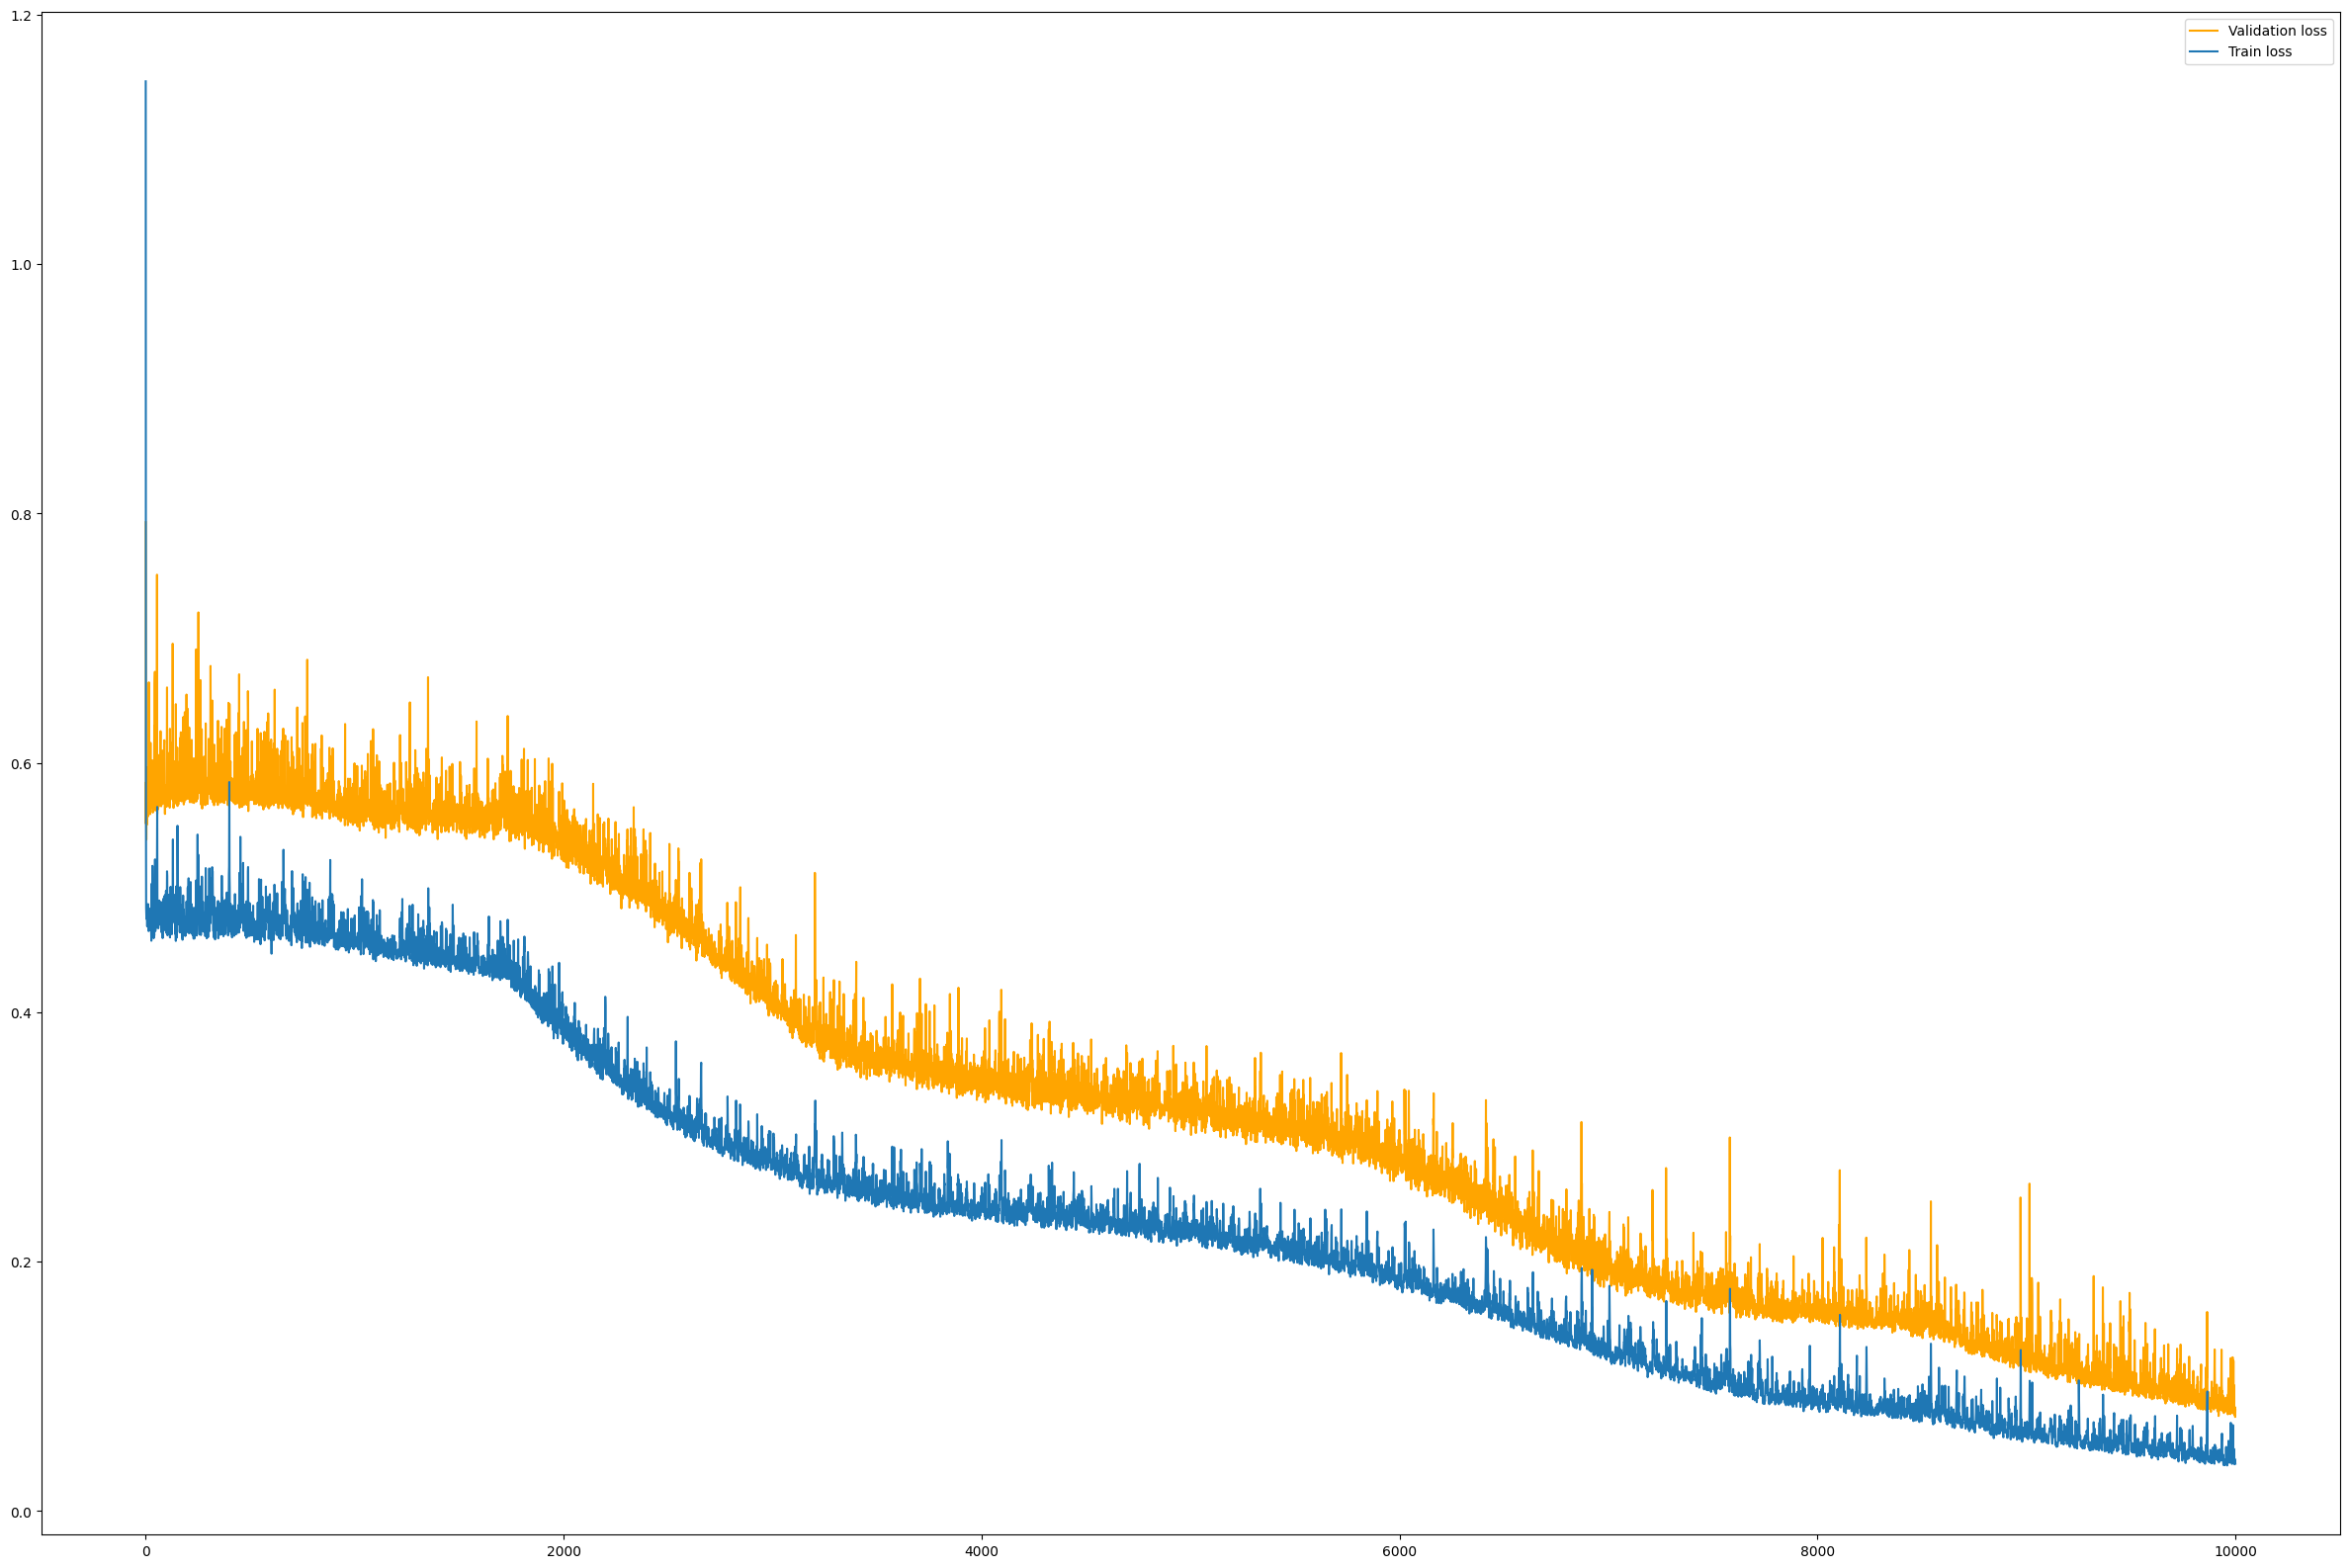

In [178]:
plt.figure(figsize=(30, 20))
plt.plot(val_loss, label='Validation loss', color='orange')
plt.plot(train_loss, label='Train loss')
plt.legend()

In [181]:
train_loss = history_callback.history['loss']
val_loss = history_callback.history['val_loss']
test_metrics = model.evaluate(x_test, y_test)
test_loss = test_metrics[model.metrics_names.index('loss')]
test_loss_array = np.array([test_loss])

2/2 [==============================] - 0s 5ms/step - loss: 0.1339 - max_absolute_error: 1.0207 - std_error: 0.3261


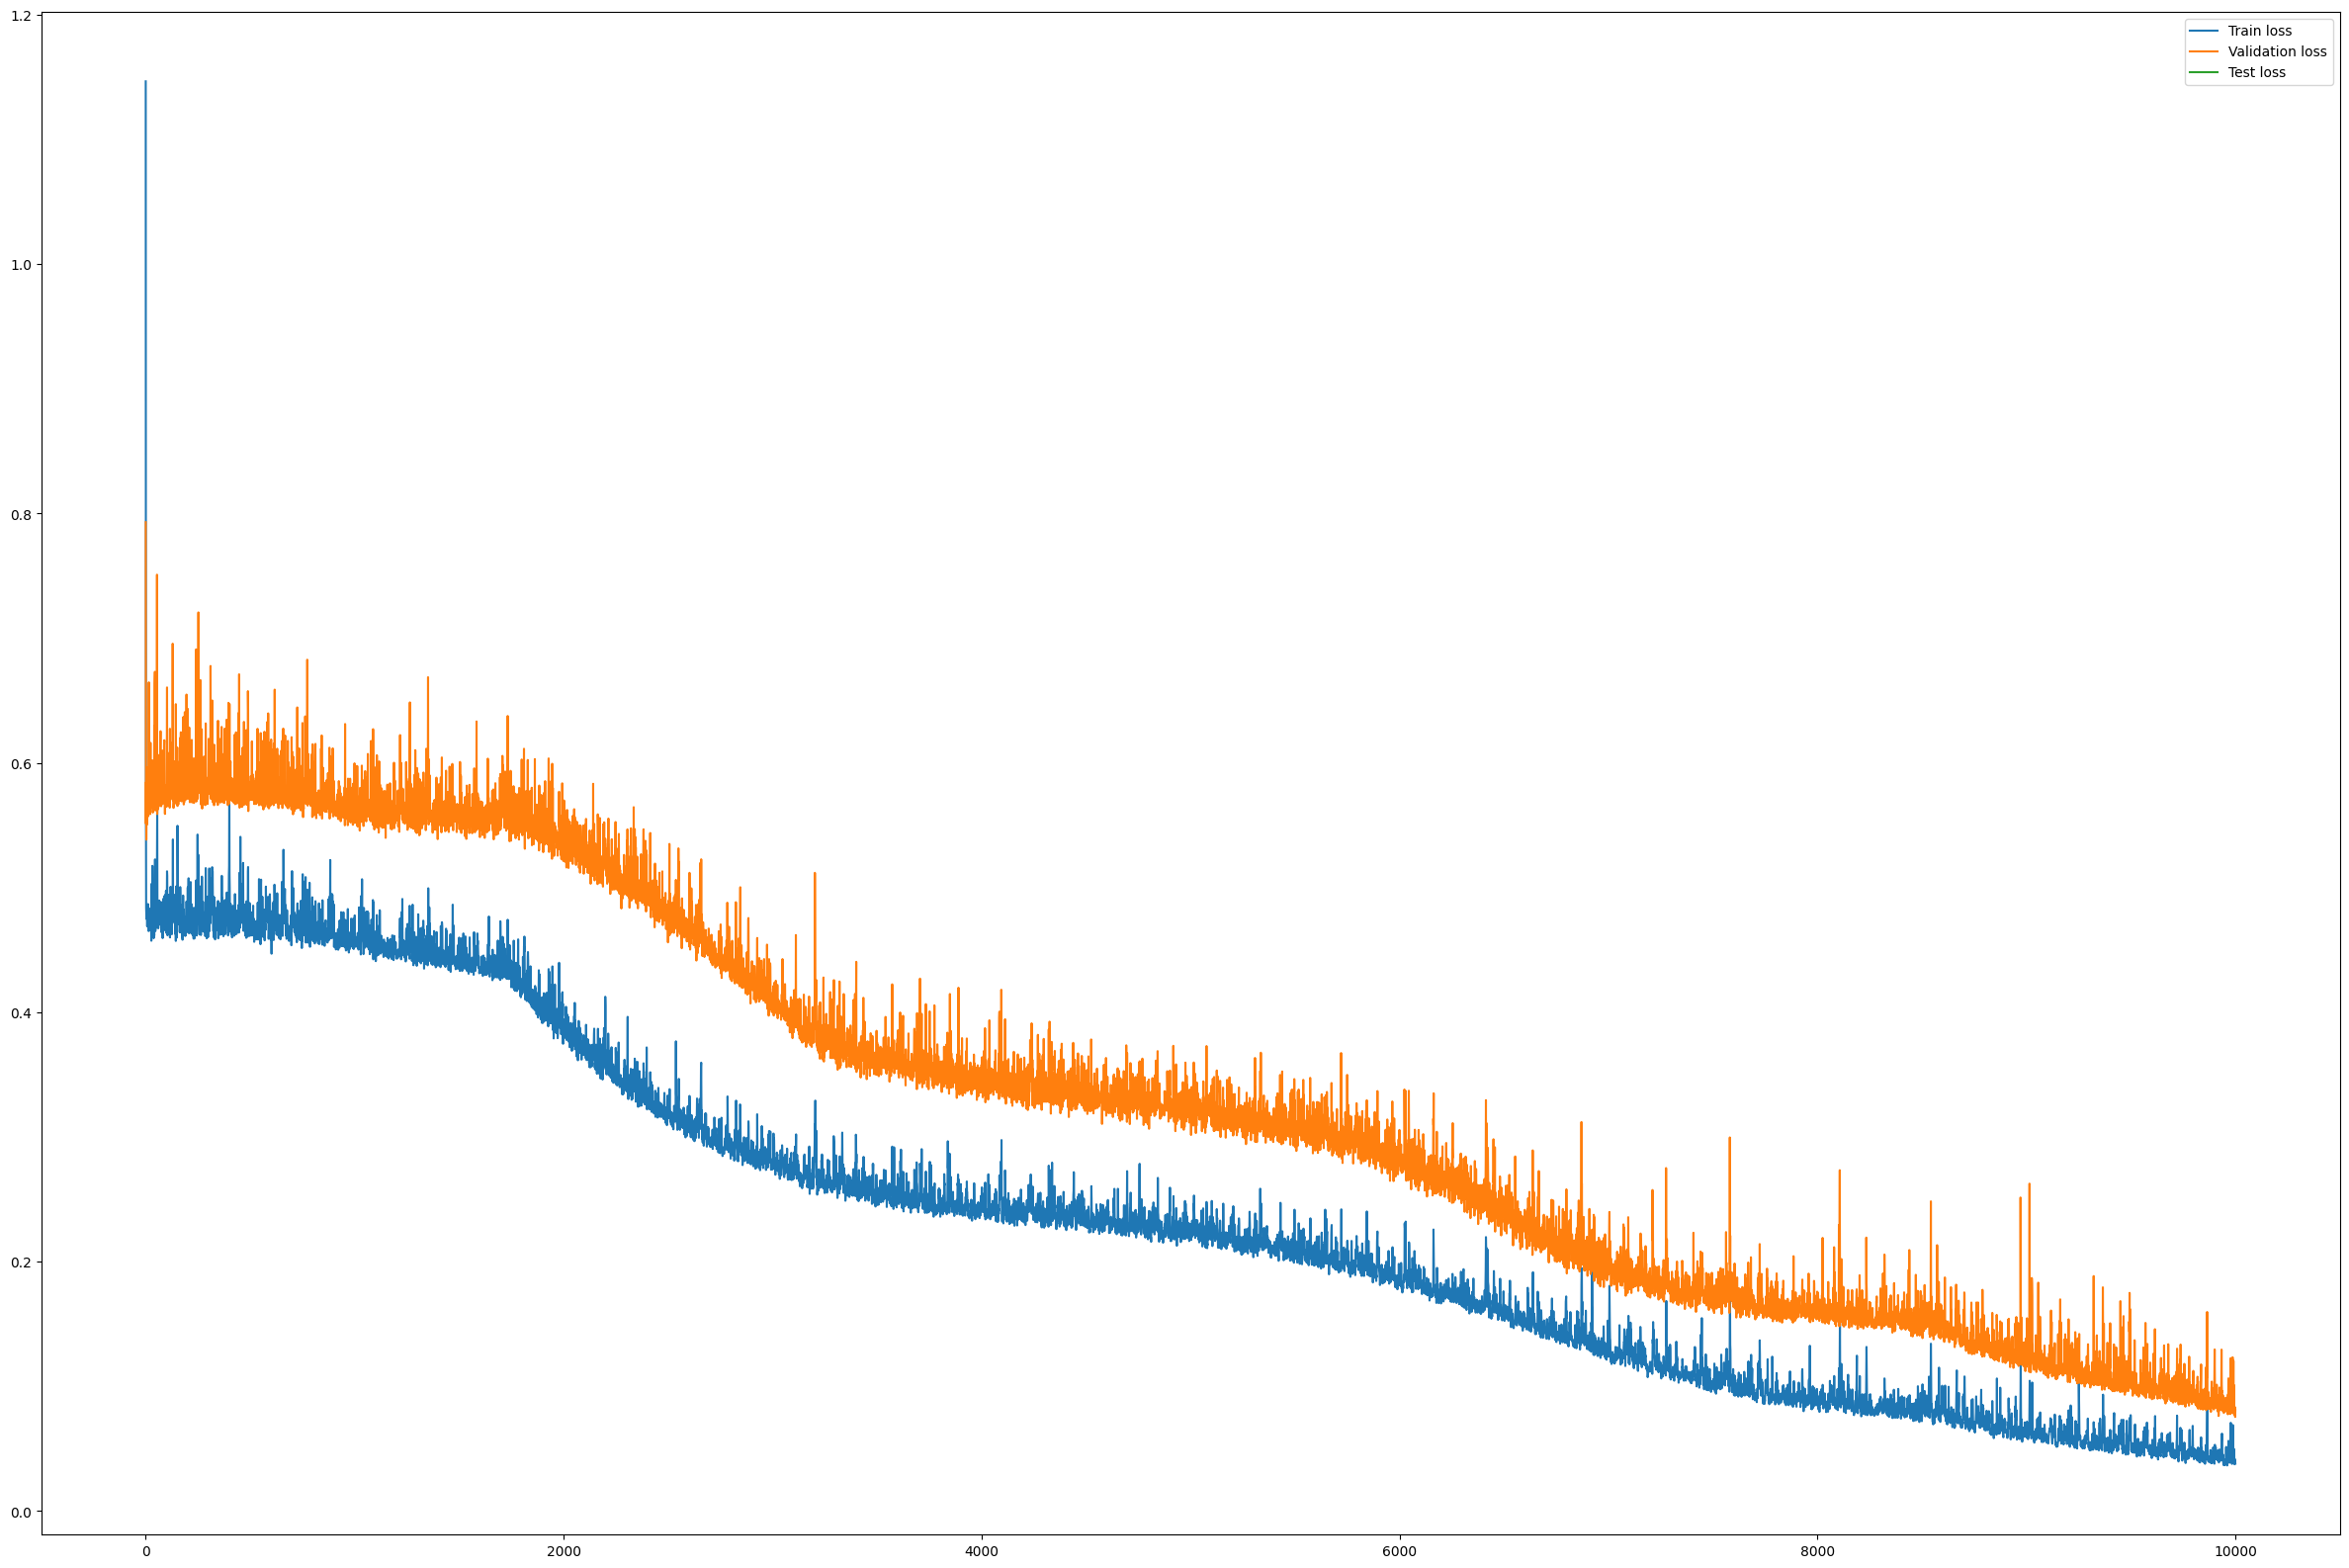

In [183]:
plt.figure(figsize=(30, 20))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Validation loss')
plt.plot(test_loss, label='Test loss')
plt.legend()

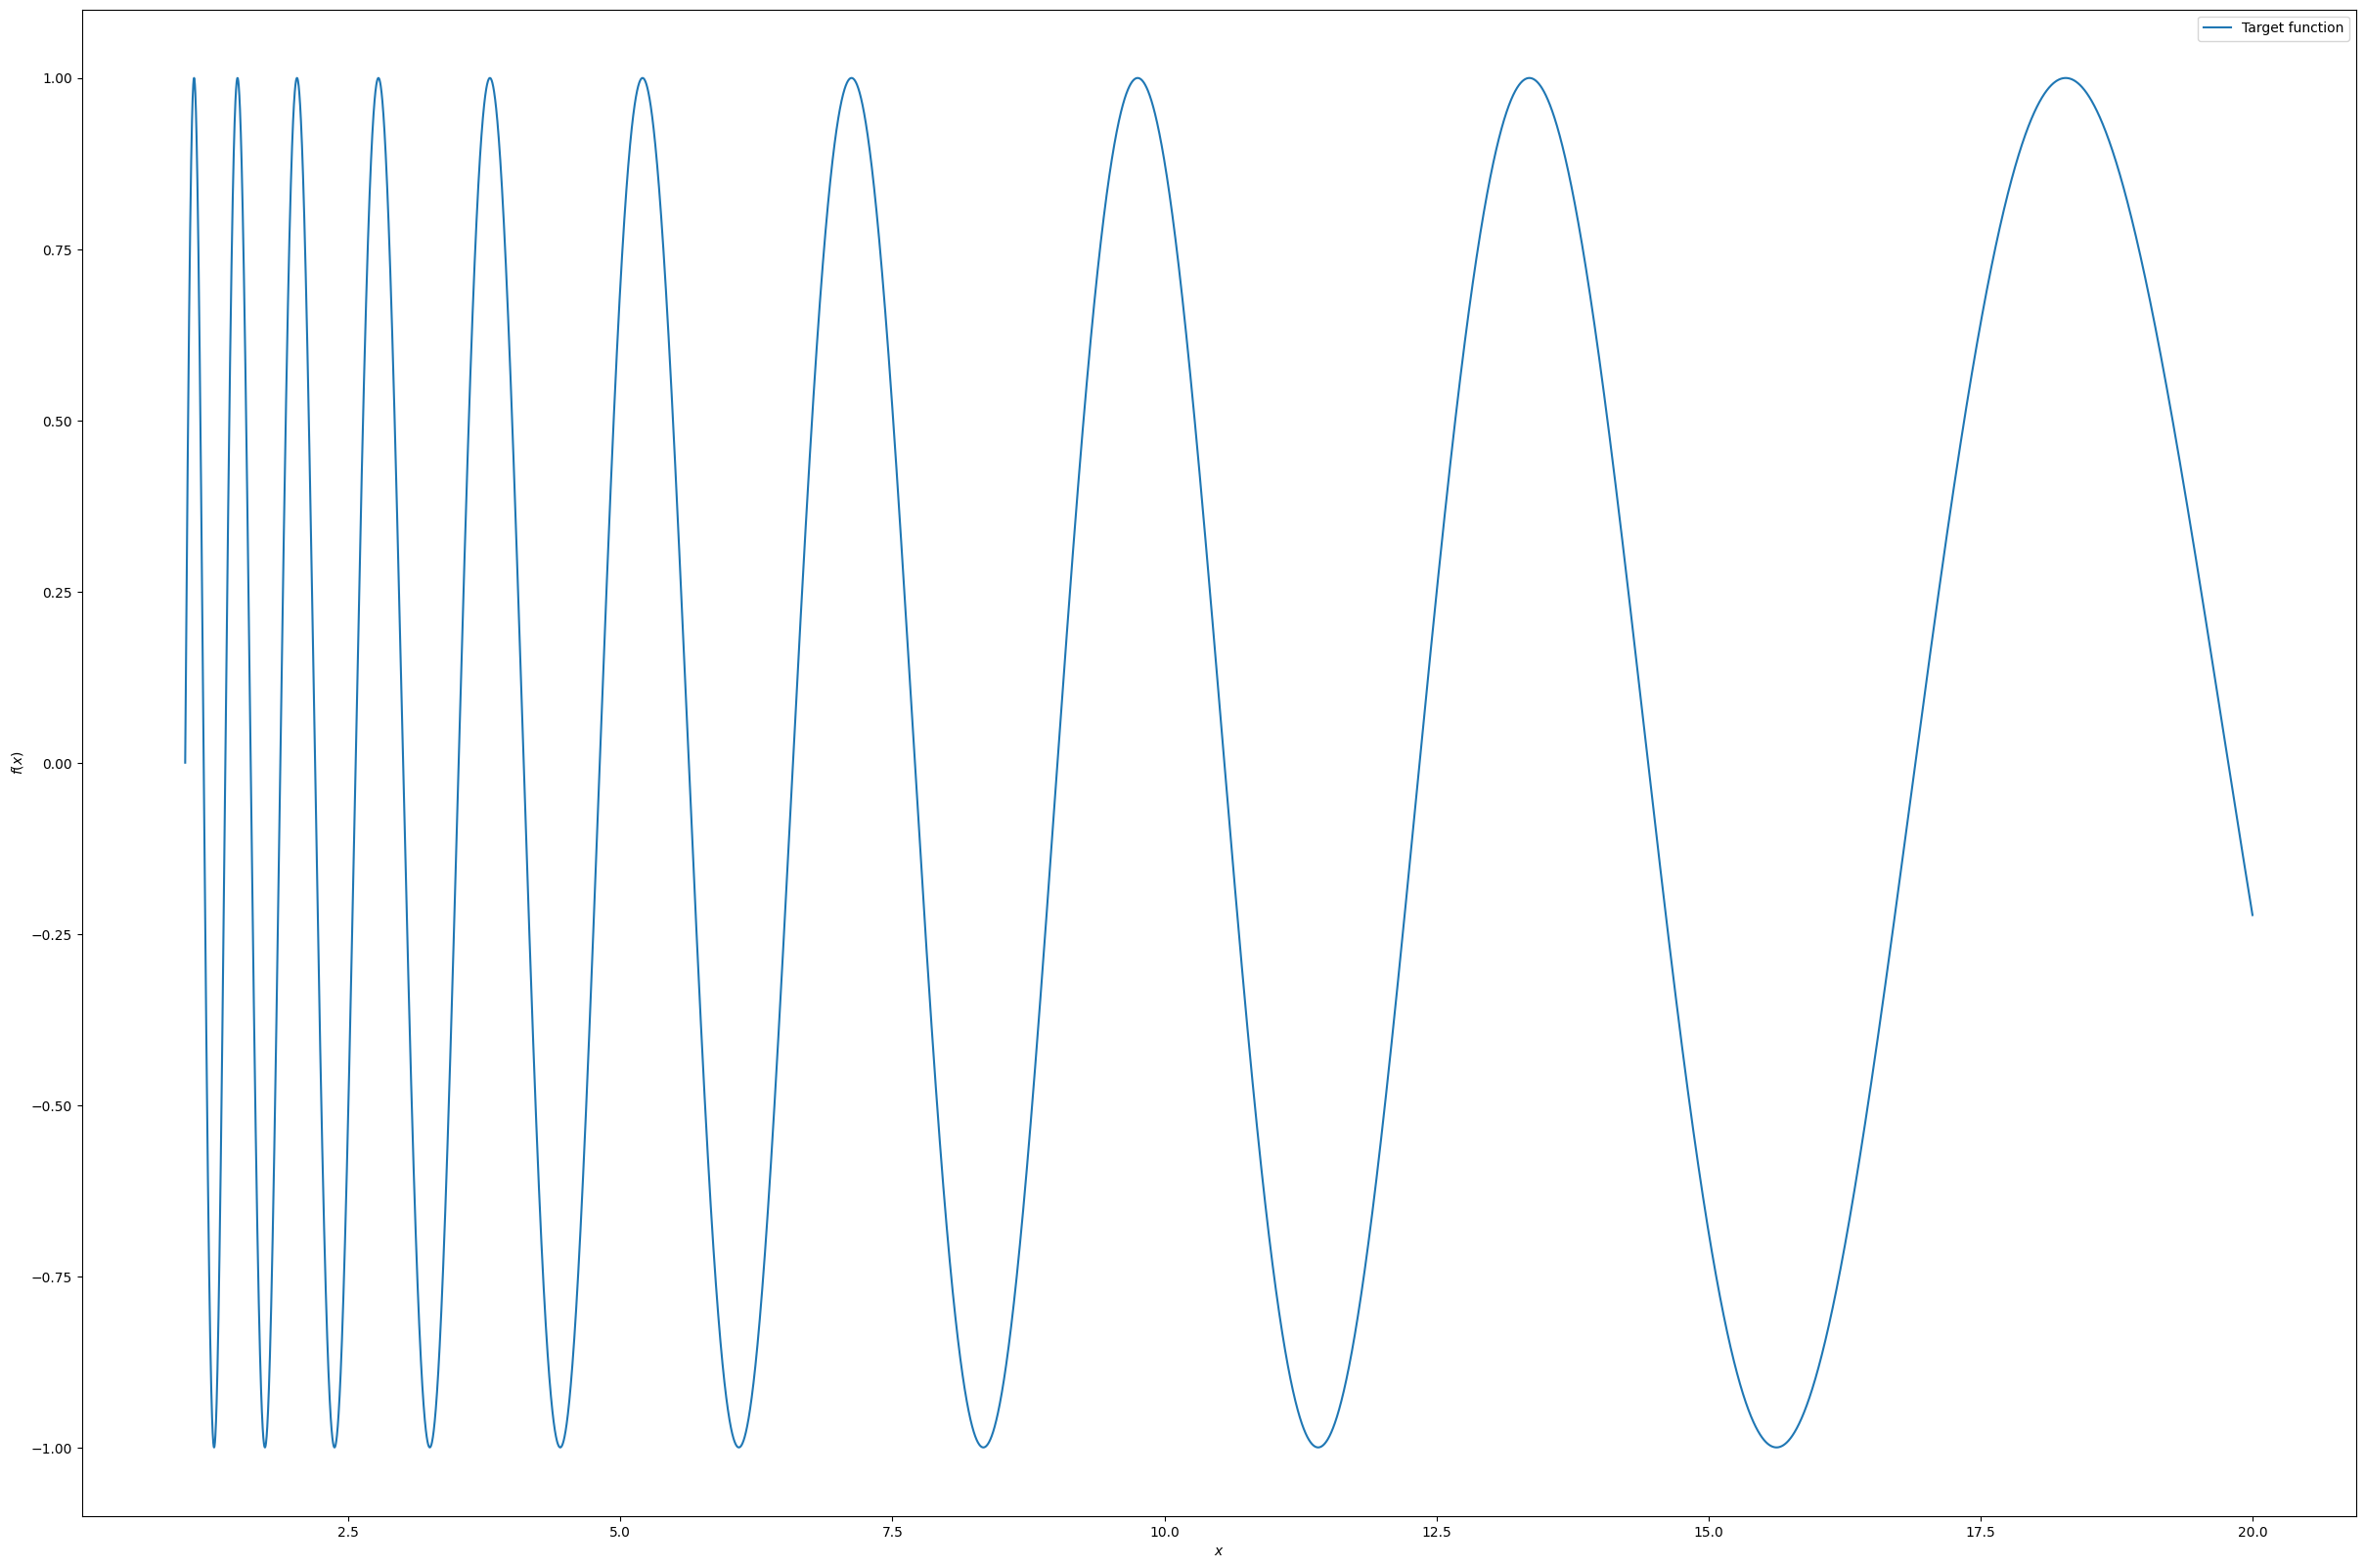

In [185]:
x_plot = np.linspace(1,20,10000)
plt.figure(figsize=(30, 20))
plt.plot(x_plot, target_function(x_plot), label='Target function')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend()